In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

## Read in Training Data

In [47]:
# data = pd.read_csv('RYANDATA_filt.csv')
data = pd.read_csv('RYANDATA_consolidated.csv')

# data.columns = ['V0', 'topic', 'authors','title','journal','year','vol_issue','doi']
print(data.columns)

Index(['V0', 'topic', 'authors', 'title', 'journal', 'year', 'vol_issue',
       'doi'],
      dtype='object')


In [48]:
papers = pd.DataFrame(data['title'])
topic = pd.DataFrame(data['topic'])
author = pd.DataFrame(data['authors'])

In [49]:
print(len(papers))
print(len(topic))
data[['title','topic']].head()

36622
36622


,title,topic
0,Preparation of adenosine-loaded electrospun na...,BONE
1,The adaption of the bony microstructure of the...,BONE
2,Effect of caffeine on ovariectomy-induced oste...,BONE
3,The effect of formalin preservation time and t...,BONE
4,Accurate and efficient plate and rod microfini...,BONE


In [50]:
topic['topic'].unique() #consolidated

array(['BONE', 'CARDIOVASCULAR', 'CELLULAR', 'COMPARATIVE',
       'DENTAL/ORAL/FACIAL', 'ERGONOMICS', 'EVOLUTION/ANTHROPOLOGY',
       'GAIT/LOCOMOTION', 'JOINT/CARTILAGE', 'METHODS', 'MODELING',
       'MUSCLE', 'NEURAL', 'ORTHOPAEDICS/SPINE', 'ORTHOPAEDICS/SURGERY',
       'POSTURE/BALANCE', 'REHABILITATION', 'SPORT/EXERCISE',
       'TENDON/LIGAMENT', 'TISSUE/BIOMATERIAL', 'TRAUMA/IMPACT',
       'VETERINARY/AGRICULTURAL', 'VISUAL/VESTIBULAR', 'HAND/FOOT',
       'PROSTHETICS/ORTHOTICS', 'ROBOTICS'], dtype=object)

In [51]:
from sklearn.preprocessing import LabelEncoder

feat = ['topic']
for x in feat:
    le = LabelEncoder()
    le.fit(list(topic[x].values))
    topic[x] = le.transform(list(topic[x]))

In [52]:
topic['topic'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 18,
       20, 21, 22, 23, 24, 25,  8, 17, 19])

In [53]:
print(le.inverse_transform([0])[0])
#save label encoder
np.save('../Models/test_many_ML_Label_Encoder.npy',le)
print('saved label encoder')

BONE
saved label encoder


In [54]:
data['everything'] = pd.DataFrame(data['title'])
print(data['everything'].head(5))

0    Preparation of adenosine-loaded electrospun na...
1    The adaption of the bony microstructure of the...
2    Effect of caffeine on ovariectomy-induced oste...
3    The effect of formalin preservation time and t...
4    Accurate and efficient plate and rod microfini...
Name: everything, dtype: object


## Clean up titles

In [55]:
def change(t):
    t = t.split()
    return ' '.join([(i) for (i) in t if i not in stop])
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
stop.append('The')
stop.append('An')
stop.append('A')
stop.append('Do')
stop.append('Is')
stop.append('In')

data['everything'].apply(change).head()

0    Preparation adenosine-loaded electrospun nanof...
1    adaption bony microstructure human glenoid cav...
2    Effect caffeine ovariectomy-induced osteoporos...
3    effect formalin preservation time temperature ...
4    Accurate efficient plate rod microfinite eleme...
Name: everything, dtype: object

## Vectorize words in titles

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1, #min occurances needed
                             max_df=0.75, #max occuraces allowed (%)
                             ngram_range=(1,2), #size range of grams (1-2 words)
                             strip_accents='unicode',
                             lowercase =True,
                             analyzer='word', 
                             token_pattern=r'\w+', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=True, 
                             stop_words = 'english')
vectors = vectorizer.fit_transform(data['everything'])
vectors.shape

(36622, 238587)

## Split Data

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
# from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(vectors,
                                                    topic['topic'],
                                                    test_size=0.2,
                                                    random_state = 0)

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

type(papers)

(29297, 238587)
(29297,)
(7325, 238587)
(7325,)


pandas.core.frame.DataFrame

# Test Models:

## Multinomial Naive Bayes

In [58]:
mnb = MultinomialNB(alpha=.45)
mnb.fit(X_train, y_train)
pred = mnb.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.40844369973385014
0.5329692832764505


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression

In [59]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver= 'sag',max_iter=500,random_state=0, multi_class='multinomial')
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.5844289554780898
0.6331740614334471


## Stochastic Gradient Descent (SGD) learning

In [60]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(max_iter=500, random_state=0, tol = 1e-3)
sgd.fit(X_train, y_train) 
pred = sgd.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.6196744251354799
0.6554266211604095


## Linear SVC

In [61]:
from sklearn.svm import LinearSVC
lsvc =LinearSVC()
lsvc.fit(X_train, y_train) 
pred = lsvc.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.6502328340258339
0.6724914675767918


# Plot Confusion Matrix 

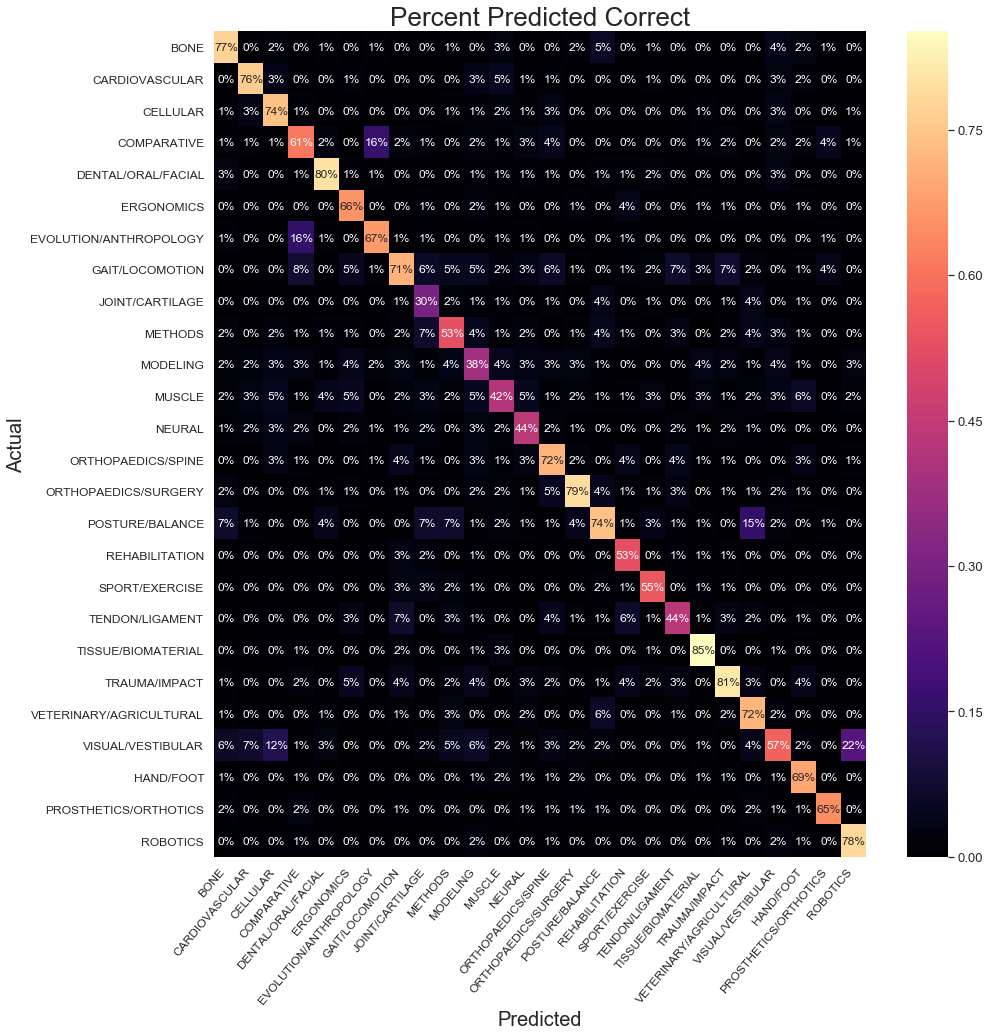

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

data['topic_id'] = data['topic'].factorize()[0]
topic_id_df = data[['topic',
                  'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id','topic']].values)

model = lsvc

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_rowsum = [sum(row) for row in conf_mat]
conf_mat_perc = conf_mat / conf_mat_rowsum
fig, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.2) #font size multiplier
sns.heatmap(conf_mat_perc, annot=True, fmt='.0%', cmap = 'magma', annot_kws={"size": 12},
            xticklabels=topic_id_df.topic.values, yticklabels=topic_id_df.topic.values)

plt.ylabel('Actual',fontsize = 20)
plt.xlabel('Predicted',fontsize = 20)
plt.yticks(size = 12)
plt.xticks(size = 12, rotation=50,ha='right')
plt.title('Percent Predicted Correct', fontsize = 26)
plt.yticks( rotation='horizontal')
fig.tight_layout(pad = 2)
plt.show()


# Table of Classification Scores

In [63]:

from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=data['topic'].unique()))

                         precision    recall  f1-score   support

                   BONE       0.71      0.77      0.74       373
         CARDIOVASCULAR       0.79      0.76      0.77       243
               CELLULAR       0.67      0.74      0.70       235
            COMPARATIVE       0.59      0.61      0.60       329
     DENTAL/ORAL/FACIAL       0.79      0.80      0.79       274
             ERGONOMICS       0.70      0.66      0.68        97
 EVOLUTION/ANTHROPOLOGY       0.73      0.67      0.70       218
        GAIT/LOCOMOTION       0.65      0.71      0.68       647
        JOINT/CARTILAGE       0.45      0.30      0.36       100
                METHODS       0.59      0.53      0.56       277
               MODELING       0.41      0.38      0.40       268
                 MUSCLE       0.53      0.42      0.47       268
                 NEURAL       0.60      0.44      0.50       149
     ORTHOPAEDICS/SPINE       0.65      0.72      0.68       349
   ORTHOPAEDICS/SURGERY 

# Test model on string

In [64]:
text = ['neuromechanical effort proxies estimation computational']
text[0] = text[0].lower()
#text = list(text)
s = (vectorizer.transform(text))
#s = vectorizer.fit_transform(df)
print (s.shape)
d = (logreg.predict(s))

le.inverse_transform(d)[0]

(1, 238587)


'MODELING'

# Save a model for later

In [70]:
from sklearn.externals import joblib
joblib.dump(mnb, '../Models/MultNB.pkl')
print ("Model Saved")

Model Saved


# Save a vectorizer for later

In [66]:
from sklearn.externals import joblib
joblib.dump(vectorizer, '../Models/test_many_ML_vectorizer.pkl')
print('Vectorizer Saved')

Vectorizer Saved


# Load a model

In [71]:
clf = joblib.load('../Models/MultNB.pkl')
clf

MultinomialNB(alpha=0.45, class_prior=None, fit_prior=True)